# Fraud Detection Modeling

This notebook contains functions for modeling fraud detection.

In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import sys
import os
import warnings
import optuna
from typing import Dict, List, Tuple, Optional, Any, Union
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                             precision_recall_curve, f1_score, roc_curve)
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE

# Ignore warnings
warnings.filterwarnings('ignore')

# Set matplotlib style
plt.style.use('ggplot')

# Configure display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
sys.path.append(os.path.abspath('..'))

# Import the utility function for one-time directory change
from src.utilities.path_utilities import ensure_parent_dir

# Change to parent directory (only happens once even if cell is re-executed)
ensure_parent_dir('notebook_setup')

Original directory: /Users/adrianhajdukiewicz/projects/private/recruitment_2025_data_biz_hackathon/notebooks
Changed directory to: /Users/adrianhajdukiewicz/projects/private/recruitment_2025_data_biz_hackathon


'/Users/adrianhajdukiewicz/projects/private/recruitment_2025_data_biz_hackathon'

In [6]:
df_merged = pd.read_csv('data/df_merged.csv')

## 1. Data Preprocessing Functions

In [7]:
def encode_categorical_features(df: pd.DataFrame, 
                               categorical_cols: Optional[List[str]] = None) -> Tuple[pd.DataFrame, Dict[str, LabelEncoder]]:
    """Encode categorical features using LabelEncoder.
    
    Args:
        df: DataFrame containing the features
        categorical_cols: List of categorical columns to encode. If None, defaults to a predefined list
        
    Returns:
        Tuple containing:
            - DataFrame with encoded features
            - Dictionary mapping column names to their corresponding LabelEncoder objects
    """
    if categorical_cols is None:
        categorical_cols = ['user_id', 'merchant_id', 'channel', 'currency', 'device', 'payment_method',
                           'education', 'primary_source_of_income', 'user_country', 'category',
                           'merchant_country', 'is_first_time_merchant']
        
        # Add any additional categorical columns extracted from location
        if 'country' in df.columns:
            categorical_cols.append('country')
        if 'city' in df.columns:
            categorical_cols.append('city')
        if 'administrative_region_1' in df.columns:
            categorical_cols.append('administrative_region_1')
    
    # Apply label encoding
    label_encoders = {}
    for col in categorical_cols:
        if col in df.columns:
            le = LabelEncoder()
            df[col + '_encoded'] = le.fit_transform(df[col].astype(str))
            label_encoders[col] = le
    
    return df, label_encoders

In [8]:
def prepare_modeling_dataset(df: pd.DataFrame, 
                            cols_to_drop: Optional[List[str]] = None,
                            categorical_cols: Optional[List[str]] = None) -> pd.DataFrame:
    """Prepare the dataset for modeling by dropping unnecessary columns.
    
    Args:
        df: DataFrame to prepare
        cols_to_drop: List of columns to drop. If None, uses default list
        categorical_cols: List of categorical columns for reference
        
    Returns:
        DataFrame ready for modeling
    """
    # Define default columns to drop if not provided
    if cols_to_drop is None:
        cols_to_drop = ['transaction_id', 'user_id', 'merchant_id', 'timestamp', 'location', 
                        'prev_timestamp', 'signup_date', 'date']
    
    # If categorical_cols is provided, extend cols_to_drop with original categorical columns
    if categorical_cols is not None:
        cols_to_drop.extend([col for col in categorical_cols if col in df.columns])
    
    # Drop specified columns that exist in the dataframe
    modeling_df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])
    
    return modeling_df

In [9]:
def clean_dataset_for_modeling(df: pd.DataFrame, 
                              date_cols: Optional[List[str]] = None) -> pd.DataFrame:
    """Clean the dataset by handling date columns, dict columns, and encoding categorical features.
    
    Args:
        df: DataFrame to clean
        date_cols: List of date/time columns to drop. If None, uses default list
        
    Returns:
        Cleaned DataFrame ready for modeling
    """
    modeling_df = df.copy()
    
    # Define date columns to drop if not provided
    if date_cols is None:
        date_cols = ['timestamp', 'date', 'signup_date', 'weekday_name']
    
    # 1. Drop date/time columns
    for col in date_cols:
        if col in modeling_df.columns:
            modeling_df = modeling_df.drop(col, axis=1)
            print(f"Dropped date/time column: {col}")
    
    # 2. Drop columns that contain dicts (e.g., 'location')
    for col in modeling_df.columns:
        if modeling_df[col].apply(lambda x: isinstance(x, dict)).any():
            modeling_df = modeling_df.drop(col, axis=1)
            print(f"Dropped dict column: {col}")
    
    # 3. Encode all object (string) columns to categorical codes
    for col in modeling_df.select_dtypes(include=['object']).columns:
        modeling_df[col] = modeling_df[col].astype('category').cat.codes
        print(f"Encoded categorical column: {col}")
    
    return modeling_df

In [10]:
def split_dataset(df: pd.DataFrame, 
                 target_col: str = 'is_fraud', 
                 test_size: float = 0.2, 
                 random_state: int = 42) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    """Split the dataset into features and target, and then into train and test sets.
    
    Args:
        df: DataFrame to split
        target_col: Name of the target column
        test_size: Proportion of the dataset to include in the test split
        random_state: Random state for reproducibility
        
    Returns:
        Tuple containing X_train, X_test, y_train, y_test
    """
    # Define features and target
    X = df.drop(target_col, axis=1)
    y = df[target_col]
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")
    print(f"Fraud samples in training set: {y_train.sum()}")
    print(f"Fraud samples in test set: {y_test.sum()}")
    
    return X_train, X_test, y_train, y_test

In [11]:
def apply_smote(X_train: pd.DataFrame, 
               y_train: pd.Series, 
               random_state: int = 42,
               apply: bool = False) -> Tuple[pd.DataFrame, pd.Series]:
    """Apply SMOTE to handle class imbalance.
    
    Args:
        X_train: Training features
        y_train: Training target
        random_state: Random state for reproducibility
        apply: Whether to actually apply SMOTE or return original data
        
    Returns:
        Tuple containing resampled X_train and y_train
    """
    if apply:
        smote = SMOTE(random_state=random_state)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
        
        print(f"Original training set shape: {X_train.shape}")
        print(f"Resampled training set shape: {X_train_resampled.shape}")
        print(f"Fraud samples in original training set: {y_train.sum()}")
        print(f"Fraud samples in resampled training set: {y_train_resampled.sum()}")
    else:
        X_train_resampled = X_train
        y_train_resampled = y_train
        print("SMOTE not applied. Using original training data.")
    
    return X_train_resampled, y_train_resampled

## 2. Hyperparameter Optimization

In [12]:
def create_optuna_objective(X_train: pd.DataFrame, 
                           y_train: pd.Series,
                           pos_weight: float = None,
                           n_splits: int = 5) -> callable:
    """Create an objective function for Optuna hyperparameter optimization.
    
    Args:
        X_train: Training features
        y_train: Training target
        pos_weight: Weight of positive class for imbalanced data
        n_splits: Number of cross-validation splits
        
    Returns:
        Objective function to be used in Optuna study
    """
    # Calculate default pos_weight if not provided
    if pos_weight is None:
        n_neg = len(y_train) - sum(y_train)
        n_pos = sum(y_train)
        pos_weight = n_neg / n_pos if n_pos > 0 else 1.0
    
    def objective(trial):
        # Define hyperparameters to optimize with well-tested ranges
        param = {
            'objective': 'binary:logistic',
            'eval_metric': 'auc',
            'booster': 'gbtree',
            'lambda': trial.suggest_float('lambda', 1e-3, 5.0, log=True),
            'alpha': trial.suggest_float('alpha', 1e-3, 5.0, log=True),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
            'n_estimators': trial.suggest_int('n_estimators', 40, 50),
            'max_depth': trial.suggest_int('max_depth', 4, 8),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
            'gamma': trial.suggest_float('gamma', 1e-8, 0.5, log=True),
            'subsample': trial.suggest_float('subsample', 0.7, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
            'scale_pos_weight': pos_weight,
            'random_state': 42
        }
        
        # Initialize cross-validation
        cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        cv_scores = []
        
        # Perform cross-validation
        for train_idx, val_idx in cv.split(X_train, y_train):
            X_train_fold = X_train.iloc[train_idx]
            y_train_fold = y_train.iloc[train_idx]
            X_val_fold = X_train.iloc[val_idx]
            y_val_fold = y_train.iloc[val_idx]
            
            # Train model
            model = xgb.XGBClassifier(**param)
            model.fit(
                X_train_fold, y_train_fold,
                eval_set=[(X_val_fold, y_val_fold)],
                verbose=False
            )
            
            # Make predictions and calculate F1 score
            y_pred = model.predict(X_val_fold)
            cv_scores.append(f1_score(y_val_fold, y_pred))
        
        # Return mean CV score
        return np.mean(cv_scores)
    
    return objective

In [13]:
def run_hyperparameter_optimization(X_train: pd.DataFrame, 
                                   y_train: pd.Series,
                                   n_trials: int = 200,
                                   pos_weight: float = None,
                                   n_splits: int = 5,
                                   plot_results: bool = True) -> Dict:
    """Run hyperparameter optimization using Optuna.
    
    Args:
        X_train: Training features
        y_train: Training target
        n_trials: Number of optimization trials
        pos_weight: Weight of positive class for imbalanced data
        n_splits: Number of cross-validation splits
        plot_results: Whether to plot optimization results
        
    Returns:
        Dict containing best parameters and study object
    """
    # Create objective function
    objective = create_optuna_objective(X_train, y_train, pos_weight, n_splits)
    
    # Create study
    study = optuna.create_study(direction='maximize')
    
    # Run optimization
    print("Starting optimization...")
    study.optimize(objective, n_trials=n_trials)
    
    # Print best parameters and score
    print("\nBest parameters:", study.best_params)
    print("Best F1 score:", study.best_value)
    
    # Analyze parameter importance
    importance = optuna.importance.get_param_importances(study)
    print("\nParameter Importance:")
    for param, score in sorted(importance.items(), key=lambda x: x[1], reverse=True):
        print(f"{param}: {score:.4f}")
    
    if plot_results:
        # Plot parameter importance
        plt.figure(figsize=(10, 6))
        importance_df = pd.DataFrame({
            'Parameter': list(importance.keys()),
            'Importance': list(importance.values())
        })
        importance_df = importance_df.sort_values('Importance', ascending=True)
        plt.barh(importance_df['Parameter'], importance_df['Importance'])
        plt.title('Parameter Importance')
        plt.xlabel('Importance Score')
        plt.tight_layout()
        plt.show()
    
    return {'best_params': study.best_params, 'study': study}

In [14]:
def plot_param_distributions(study: optuna.study.Study, figsize: Tuple[int, int] = (15, 15)) -> None:
    """Plot parameter distributions from an Optuna study.
    
    Args:
        study: The Optuna study object
        figsize: Size of the figure (width, height)
    """
    trials_df = study.trials_dataframe()
    param_names = [col for col in trials_df.columns if col.startswith('params_')]
    
    fig, axes = plt.subplots(3, 3, figsize=figsize)
    axes = axes.flatten()
    
    for idx, param_name in enumerate(param_names):
        if idx < len(axes):
            ax = axes[idx]
            param_name_clean = param_name[7:]  # Remove 'params_' prefix
            ax.scatter(trials_df[param_name], trials_df['value'])
            ax.set_xlabel(param_name_clean)
            ax.set_ylabel('F1 Score')
            ax.set_title(f'{param_name_clean} vs F1 Score')
    
    plt.tight_layout()
    plt.show()

## 3. Model Training and Evaluation

In [15]:
def train_xgb_model(X_train: pd.DataFrame, 
                   y_train: pd.Series,
                   X_test: pd.DataFrame = None,
                   y_test: pd.Series = None,
                   params: Dict = None,
                   verbose: int = 100) -> xgb.XGBClassifier:
    """Train an XGBoost model with the given parameters.
    
    Args:
        X_train: Training features
        y_train: Training target
        X_test: Test features for evaluation during training
        y_test: Test target for evaluation during training
        params: Dictionary of model parameters
        verbose: Verbosity of training output
        
    Returns:
        Trained XGBClassifier model
    """
    # Set default parameters if not provided
    if params is None:
        n_neg = len(y_train) - sum(y_train)
        n_pos = sum(y_train)
        scale_pos_weight = n_neg / n_pos if n_pos > 0 else 1.0
        
        params = {
            'objective': 'binary:logistic',
            'n_estimators': 40,
            'learning_rate': 0.1,
            'max_depth': 5,
            'min_child_weight': 1,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'gamma': 0,
            'scale_pos_weight': scale_pos_weight,
            'random_state': 42,
            'eval_metric': 'auc'
        }
    
    # Convert categorical variables to codes
    X_train = X_train.apply(lambda x: x.cat.codes if x.dtype.name == 'category' else x)
    if X_test is not None:
        X_test = X_test.apply(lambda x: x.cat.codes if x.dtype.name == 'category' else x)
    
    # Initialize and train model
    model = xgb.XGBClassifier(**params)
    
    # Set up evaluation sets
    eval_sets = [(X_train, y_train)]
    if X_test is not None and y_test is not None:
        eval_sets.append((X_test, y_test))
    
    # Train model
    model.fit(
        X_train, y_train,
        eval_set=eval_sets,
        verbose=verbose
    )
    
    return model

In [16]:
def plot_feature_importance(model: xgb.XGBClassifier, 
                           max_features: int = 20,
                           importance_type: str = 'gain',
                           figsize: Tuple[int, int] = (12, 8)) -> pd.DataFrame:
    """Plot and return feature importance from a trained XGBoost model.
    
    Args:
        model: Trained XGBClassifier model
        max_features: Maximum number of features to display
        importance_type: Type of feature importance ('gain', 'weight', 'cover', 'total_gain', 'total_cover')
        figsize: Size of the figure (width, height)
        
    Returns:
        DataFrame with feature importance scores
    """
    # Plot feature importance
    plt.figure(figsize=figsize)
    xgb.plot_importance(model, max_num_features=max_features, importance_type=importance_type)
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.show()
    
    # Get feature importance scores
    feature_importance = model.get_booster().get_score(importance_type=importance_type)
    importance_df = pd.DataFrame({
        'Feature': list(feature_importance.keys()),
        'Importance': list(feature_importance.values())
    }).sort_values('Importance', ascending=False).head(max_features)
    
    return importance_df

In [17]:
def evaluate_model(model: xgb.XGBClassifier, 
                  X_test: pd.DataFrame, 
                  y_test: pd.Series) -> Dict[str, float]:
    """Evaluate a trained model and return performance metrics.
    
    Args:
        model: Trained classification model
        X_test: Test features
        y_test: Test target
        
    Returns:
        Dictionary containing performance metrics
    """
    # Convert categorical variables to codes if needed
    X_test = X_test.apply(lambda x: x.cat.codes if x.dtype.name == 'category' else x)
    
    # Make predictions
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred)
    
    # Print evaluation results
    print(f"ROC-AUC Score: {roc_auc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    return {
        'roc_auc': roc_auc,
        'f1_score': f1,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

In [18]:
# Plot ROC curve
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

NameError: name 'y_test' is not defined

In [ ]:
def print_classification_report(y_test: pd.Series, y_pred: np.ndarray) -> None:
    """Print classification report with precision, recall, and F1-score.
    
    Args:
        y_test: True target values
        y_pred: Predicted target values
    """
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.51      0.66     91518
           1       0.10      0.60      0.17      8482

    accuracy                           0.52    100000
   macro avg       0.52      0.55      0.42    100000
weighted avg       0.86      0.52      0.62    100000



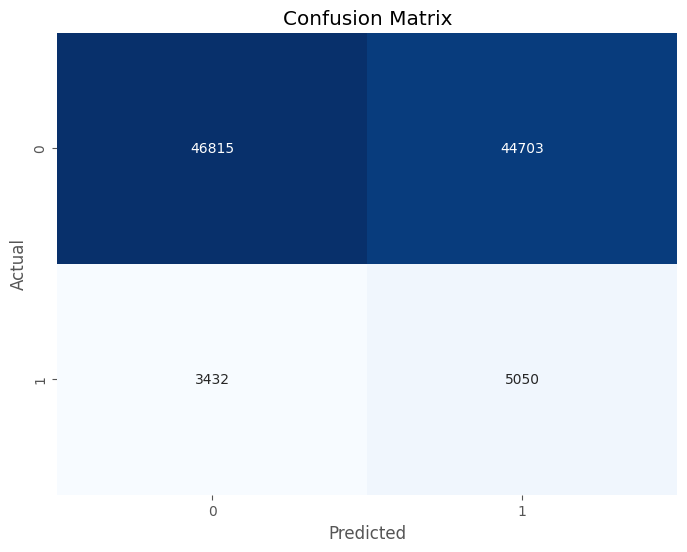

In [ ]:
def plot_confusion_matrix(y_test: pd.Series, 
                         y_pred: np.ndarray, 
                         figsize: Tuple[int, int] = (8, 6)) -> None:
    """Plot confusion matrix to visualize model performance.
    
    Args:
        y_test: True target values
        y_pred: Predicted target values
        figsize: Size of the figure (width, height)
    """
    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

## 5. Example Usage

Below is an example of how to use the functions defined above.

In [ ]:
# Example usage of the pipeline
# Uncomment the code below to run the full pipeline

# Preprocess data
df_merged, label_encoders = encode_categorical_features(df_merged)
modeling_df = prepare_modeling_dataset(df_merged)
modeling_df = clean_dataset_for_modeling(modeling_df)

# Split dataset
X_train, X_test, y_train, y_test = split_dataset(modeling_df)

# Handle class imbalance
X_train_resampled, y_train_resampled = apply_smote(X_train, y_train, apply=False)

# Train model with default parameters
model = train_xgb_model(X_train_resampled, y_train_resampled, X_test, y_test)

# Evaluate model
metrics = evaluate_model(model, X_test, y_test)

# Visualize results
importance_df = plot_feature_importance(model)
plot_roc_curve(y_test, metrics['y_pred_proba'])
print_classification_report(y_test, metrics['y_pred'])
plot_confusion_matrix(y_test, metrics['y_pred'])

In [ ]:
# # Alternatively, use the complete pipeline with a single function
# results = run_fraud_detection_pipeline(
#     df_merged, 
#     optimize_hyperparameters=True, 
#     apply_smote_resampling=False,
#     n_trials=50
# )